In [1]:
import os

#import matplotlib
#matplotlib.use('MACOSX')
#for some reason if I run these 2 lines - it doesnt plot at all any more.


import numpy as np
import mne
import matplotlib.pyplot as plt
from copy import deepcopy
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch


In [4]:
#Load data

#! use relative paths!

kath_raw_file = os.path.join('Katharinas_Data','sub_HT05ND16', '210811', 'mikado-1.fif')                               
raw = mne.io.read_raw_fif(kath_raw_file)

Opening raw data file Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif...


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_74785/519485196.py:6: RuntimeWarning: This filename (Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(kath_raw_file)


    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 1809000 ... 3375999 =   1809.000 ...  3375.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Katharinas_Data/sub_HT05ND16/210811/mikado-2.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 

In [5]:
#Filter the data

def filtering_data(data=None,l_freq=None, h_freq=None, method='iir'):
    # Filtering the data. Recommended: 1-100Hz bandpass or 0.5-100 Hz - better for frequency spectrum

    # method='iir' - I m using here the Butterworth filter similar to filtfilt in matlab, like we  
    # did in the course with eeg data. such filter creates no time shift, since it filters forward and backward.
    # But we might use a different filter as well. I dont know if this one is the best possible option.

    #Data has to be loaded into mememory before filetering:
    data.load_data(verbose=True)
    raw_bandpass = data.copy()
    raw_bandpass.filter(l_freq=l_freq, h_freq=h_freq, picks='meg', method=method, iir_params=None)

    return(raw_bandpass)


In [6]:
#try

filtered_d=filtering_data(data=raw,l_freq=1, h_freq=100, method='iir')

Reading 0 ... 3389999  =      0.000 ...  3389.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



In [7]:
#%% RMSE - general function to use in other functions
#STD CALCULATION IS MUCH LESS COdE BUT TAKES LONGER THAN RMSE

def RMSE(data_mags=None, data_grads=None):

    # https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python

    from sklearn.metrics import mean_squared_error

    #Magnitometers:
    y_actual_mags=data_mags
    y_predicted_mags=data_mags.mean(axis=1)

    rmse_mags = np.zeros(len(y_predicted_mags)) #RMSE of all magnetometers

    for i in range(len(y_predicted_mags)):
        y_predicted_vec_mags=np.ones(len(y_actual_mags[0]))*y_predicted_mags[i]
        rmse_mags[i] = mean_squared_error(y_actual_mags[i, :], y_predicted_vec_mags, squared=False)


    #Gradiometers:
    y_actual_grads=data_grads
    y_predicted_grads=data_grads.mean(axis=1)

    rmse_grads = np.zeros(len(y_predicted_grads)) #RMSE of all gradiometers

    for i in range(len(y_predicted_grads)):
        y_predicted_vec_grads=np.ones(len(y_actual_grads[0]))*y_predicted_grads[i]
        rmse_grads[i] = mean_squared_error(y_actual_grads[i, :], y_predicted_vec_grads, squared=False)

    return(rmse_mags, rmse_grads)


In [ ]:
def RMSE_epoch_new(data_mags=None, data_grads=None):
    events = mne.find_events(raw_bandpass, stim_channel='STI101', min_duration=1.2)
    epochs = mne.Epochs(raw_bandpass, events, tmin=-0.2, tmax=1, preload=True, baseline = None) #, event_id=event_dict, reject=reject_criteria)
    df = epochs.to_data_frame(time_format=None, scalings=dict(mag=1, grad=1))

    eps=list(range(0,len(events))) #list of epoch numbers

    for ep in eps:   #loop over each epoch
    #Rmse need data of only mags and grads separately:

        #separate data of this epoch:
        #then separate mags of this ep and grads:
        rmse_ep_m, rmse_ep_g=RMSE(data_mags=None, data_grads=None)






In [8]:
# Root mean squared error calculation (or STD - same result) over all data:

def RMSE_meg_all(data=None, std_lvl=1): #, min_duration_event=1, epoch_tmin=-0.2, epoch_tmax=1):
    #give path to directory and then it should auto find the data file when bids compliant.

    #Separate mags and grads:
    mags = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T)')]
    grads = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T_M)')]
  

    # Separate data for mags and grads in 2 arrays.
    selected_mags = [item[1] for item in mags]
    selected_grads = [item[1] for item in grads]
    data_mags, times = data[selected_mags, :]  
    data_grads, times = data[selected_grads, :]  

    # %% Calculate STD or RMSE of each channel

    #Calculate RMSE for each channel (separated mags and grads) - for the entire time duration:
    std_mags, std_grads = RMSE(data_mags=data_mags, data_grads=data_grads)

    #STD (if wanna use insted of RMSE. it will exactly replace the RMSE function above):
    #std_mags=np.std(data_mags, axis=1) #calculate std of all magnetometers (along second dimantion)
    #std_grads=np.std(data_grads, axis=1) #calculate std of all gradiometers (along second dimantion)


    # Check if channel data is within 1 std over all channels.
    # COMMENT: can use -3 to 3 (or other number) std istead of -1/+1 std, but this can adjusted later. 
    # 1 std is too narrow, gives way too many bad channels.

    std_std_mags=np.std(std_mags)
    std_std_grads=np.std(std_grads)

    mean_std_mags=np.mean(std_mags)
    mean_std_grads=np.mean(std_grads)

    ch_large_std_mags= np.where(std_mags > mean_std_mags+std_lvl*std_std_mags) # | std_mags < mean_std_magn-std_std_mags)
    ch_large_std_grads= np.where(std_grads > mean_std_grads+std_lvl*std_std_grads) # | std_grads < mean_std_grad-std_std_grads)

    ch_small_std_mags= np.where(std_mags < mean_std_mags-std_lvl*std_std_mags)
    ch_small_std_grads= np.where(std_grads < mean_std_grads-std_lvl*std_std_grads)


    magn_channel_big_std=np.array(mags)[ch_large_std_mags[0]]
    grad_channel_big_std=np.array(grads)[ch_large_std_grads[0]]

    magn_channel_small_std=np.array(mags)[ch_small_std_mags[0]]
    grad_channel_small_std=np.array(grads)[ch_small_std_grads[0]]

    print('Magnetometers with high STD: ', magn_channel_big_std)
    print('Gradiometers with high STD: ',grad_channel_big_std)

    print('Magnetometers with low STD: ', magn_channel_small_std)
    print('Gradiometers with low STD: ',grad_channel_small_std)


    #PLOT CHANNELS WITH HIGH-LOW STD. DO WE WANT THAT?
    from matplotlib import pyplot as plt
    #%matplotlib qt
    #%matplotlib inline

    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('STDs')
    ax1.plot(list(range(1, len(std_mags)+1)), std_mags)
    ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags]*len(std_mags))
    ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags-std_lvl*std_std_mags]*len(std_mags))
    ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags+std_lvl*std_std_mags]*len(std_mags))
    ax1.set(xlabel='Magnetometer', ylabel='STD')

    ax2.plot(list(range(1, len(std_grads)+1)), std_grads)
    ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads]*len(std_grads))
    ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads-std_lvl*std_std_grads]*len(std_grads))
    ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads+std_lvl*std_std_grads]*len(std_grads))
    ax2.set(xlabel='Gradiometer', ylabel='STD')

    plt.show()


    #Return the channel names with STD over the set STD level and under the set negative STD level.
    return(magn_channel_big_std, grad_channel_big_std, magn_channel_small_std, grad_channel_small_std)


    #CAN ADD OPTIONAL PLOTTING OF SOME CHANNELS WITH HIGH/LOW STD. DO WE BEED THAT?
    #WHAT DO WE WANT TO GIVE AS OUTPUT HERE? NEED PLOTS, NEED LIST OF CHANNELS?

Magnetometers with high STD:  [['MEG0221' '26']
 ['MEG0341' '44']
 ['MEG0511' '59']
 ['MEG0531' '65']
 ['MEG0611' '71']
 ['MEG0641' '80']
 ['MEG0941' '110']
 ['MEG1031' '119']
 ['MEG1441' '170']
 ['MEG1711' '197']
 ['MEG1721' '200']
 ['MEG1831' '215']
 ['MEG1841' '218']
 ['MEG2231' '263']
 ['MEG2331' '275']
 ['MEG2431' '287']
 ['MEG2611' '305']
 ['MEG2631' '311']]
Gradiometers with high STD:  [['MEG0132' '18']
 ['MEG0142' '21']
 ['MEG0213' '25']
 ['MEG0442' '57']
 ['MEG0533' '67']
 ['MEG0542' '69']
 ['MEG0713' '85']
 ['MEG0933' '109']
 ['MEG0942' '111']
 ['MEG1012' '114']
 ['MEG1042' '123']
 ['MEG1243' '148']
 ['MEG1313' '151']
 ['MEG1343' '160']
 ['MEG1422' '165']
 ['MEG1442' '171']
 ['MEG1512' '174']
 ['MEG1532' '180']
 ['MEG1533' '181']
 ['MEG1643' '196']
 ['MEG1732' '204']
 ['MEG1833' '217']
 ['MEG2313' '271']
 ['MEG2332' '276']
 ['MEG2432' '288']
 ['MEG2512' '294']
 ['MEG2533' '301']
 ['MEG2622' '309']
 ['MEG2643' '316']]
Magnetometers with low STD:  [['MEG0211' '23']
 ['MEG0431' 

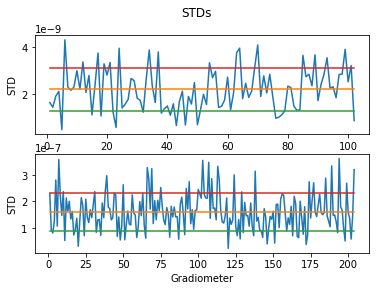

(array([['MEG0221', '26'],
        ['MEG0341', '44'],
        ['MEG0511', '59'],
        ['MEG0531', '65'],
        ['MEG0611', '71'],
        ['MEG0641', '80'],
        ['MEG0941', '110'],
        ['MEG1031', '119'],
        ['MEG1441', '170'],
        ['MEG1711', '197'],
        ['MEG1721', '200'],
        ['MEG1831', '215'],
        ['MEG1841', '218'],
        ['MEG2231', '263'],
        ['MEG2331', '275'],
        ['MEG2431', '287'],
        ['MEG2611', '305'],
        ['MEG2631', '311']], dtype='<U21'),
 array([['MEG0132', '18'],
        ['MEG0142', '21'],
        ['MEG0213', '25'],
        ['MEG0442', '57'],
        ['MEG0533', '67'],
        ['MEG0542', '69'],
        ['MEG0713', '85'],
        ['MEG0933', '109'],
        ['MEG0942', '111'],
        ['MEG1012', '114'],
        ['MEG1042', '123'],
        ['MEG1243', '148'],
        ['MEG1313', '151'],
        ['MEG1343', '160'],
        ['MEG1422', '165'],
        ['MEG1442', '171'],
        ['MEG1512', '174'],
        ['MEG1532

In [9]:
#Try:

RMSE_meg_all(data=filtered_d, std_lvl=1)

In [18]:
# STD over epochs. 

def RMSE_meg_epoch(data=None, stim_channel='STI101', std_lvl=1, min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1):
    #stim_channel name is users input. but we can also let mne find it itself if 'None' is set? mne seems to have such function.

    #Find events and epochs:
    events = mne.find_events(data, stim_channel=stim_channel, min_duration=min_duration_event)
    epochs = mne.Epochs(data, events, tmin=epoch_tmin, tmax=epoch_tmax, preload=True, baseline = None) #, event_id=event_dict, reject=reject_criteria)

    #Present epochs as data frame:
    df = epochs.to_data_frame(time_format=None, scalings=dict(mag=1, grad=1))


    # 1) Loop over the epochs of each channel and check for every separate magn and grad and calculate std
    import pandas as pd
    eps=list(range(0,len(events))) #list of epoch numbers

    #Separate mags and grads:
    mags = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T)')]
    grads = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T_M)')]
    
    mags_names = [mag[0] for mag in mags]
    grads_names = [grad[0] for grad in grads]

    combined_names = {"mags": mags_names, "grads": grads_names}

    dict_mags = {}
    dict_grads = {}

    for ep in eps: #loop over each epoch
        rows_for_ep = [row for row in df.iloc if row.epoch == ep]

        std_epoch = {"mags": [], "grads": []}

        for key_of_list in combined_names: #loop over mags, then grads

            for ch_name in combined_names[key_of_list]: #loop over channel names
                
                data_ch_epoch = [row_m[ch_name] for row_m in rows_for_ep]

                std_ch_ep = np.std(data_ch_epoch)   #HERE CAN ALSO REPLACE STD WITH RMSE CALCULATION FOR SPEED!

                std_epoch[key_of_list].append(std_ch_ep)

        dict_mags[ep] = std_epoch["mags"]
        dict_grads[ep] = std_epoch["grads"]

    df_std_mags = pd.DataFrame(dict_mags, index=mags_names)
    df_std_grads = pd.DataFrame(dict_grads, index=grads_names)

    # Create csv file  for the user:
    # Directory
    csv_folder = "csv files"
    
    # Parent Directory path
    parent_dir = os.path.dirname(os.path.abspath('Funks.ipynb')) 
    
    # Path
    path = os.path.join(parent_dir, csv_folder)

    if os.path.isdir(path)==False: #if directory doesnt exist yet - create
        os.mkdir(path)

    file_path_m = os.path.join(path, 'std_mags_per_epoch.csv')
    df_std_mags.to_csv(file_path_m)

    file_path_g = os.path.join(path, 'std_grads_per_epoch.csv')
    df_std_grads.to_csv(file_path_g)

    # 2) Check (which epochs for which channel) are over 1STD (or 2, 3, ets STDs) for (this epoch for all channels)

    #Find what is 1 std over all channels per 1 epoch:
    std_std_mags_per_epoch=[]
    std_std_grads_per_epoch=[]
    mean_std_mags_per_epoch=[]
    mean_std_grads_per_epoch=[]

    for ep in eps: #goes over each epoch
        std_std_mags_per_epoch.append(np.std(df_std_mags.iloc[:, ep])) #std of stds of all channels of every single epoch
        std_std_grads_per_epoch.append(np.std(df_std_grads.iloc[:, ep]))

        mean_std_mags_per_epoch.append(np.mean(df_std_mags.iloc[:, ep])) #mean of stds of all channels of every single epoch
        mean_std_grads_per_epoch.append(np.mean(df_std_grads.iloc[:, ep]))


    df_ch_ep_large_std_mags=df_std_mags
    df_ch_ep_large_std_grads=df_std_grads

    df_ch_ep_small_std_mags=df_std_mags
    df_ch_ep_small_std_grads=df_std_grads

    #Now see which channles in epoch are over 1 std or under -1 std:
    for ep in eps: #goes over each epoch   
        df_ch_ep_large_std_mags.iloc[:,ep] = df_std_mags.iloc[:,ep] > mean_std_mags_per_epoch[ep]+std_lvl*std_std_mags_per_epoch[ep] #magnetometers
        df_ch_ep_large_std_grads.iloc[:,ep] = df_std_grads.iloc[:,ep] > mean_std_grads_per_epoch[ep]+std_lvl*std_std_grads_per_epoch[ep] #gradiometers

        df_ch_ep_small_std_mags.iloc[:,ep] = df_std_mags.iloc[:,ep] < mean_std_mags_per_epoch[ep]-std_lvl*std_std_mags_per_epoch[ep] #magnetometers
        df_ch_ep_small_std_grads.iloc[:,ep] = df_std_grads.iloc[:,ep] < mean_std_grads_per_epoch[ep]-std_lvl*std_std_grads_per_epoch[ep] #gradiometers


    # Create csv file  for the user:
    file_path_m_large = os.path.join(path, 'Large_std_mags_per_epoch.csv')
    df_ch_ep_large_std_mags.to_csv(file_path_m_large)

    file_path_g_large = os.path.join(path, 'Large_std_grads_per_epoch.csv')
    df_ch_ep_large_std_grads.to_csv(file_path_g_large)

    file_path_m_small = os.path.join(path, 'Small_std_mags_per_epoch.csv')
    df_ch_ep_small_std_mags.to_csv(file_path_m_small)

    file_path_g_small = os.path.join(path, 'Small_std_grads_per_epoch.csv')
    df_ch_ep_small_std_grads.to_csv(file_path_g_small)

    return(df, df_ch_ep_large_std_mags) #to check


In [19]:
#try

df, df_ch_ep_large_std_mags=RMSE_meg_epoch(data=filtered_d, stim_channel='STI101', std_lvl=1, min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1)

Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
37 events found
Event IDs: [ 9 19 20 21 22]
Not setting metadata
Not setting metadata
37 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Loading data for 37 events and 1201 original time points ...


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_74785/1092705993.py:7: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(data, stim_channel=stim_channel, min_duration=min_duration_event)


0 bad epochs dropped


In [25]:
#Find events and epochs:
std_lvl=1
min_duration_event=1.2
epoch_tmin=-0.2
epoch_tmax=1
events = mne.find_events(filtered_d, stim_channel='STI101', min_duration=min_duration_event)
epochs = mne.Epochs(filtered_d, events, tmin=epoch_tmin, tmax=epoch_tmax, preload=True, baseline = None) #, event_id=event_dict, reject=reject_criteria)


eps=list(range(0,len(events))) #list of epoch numbers

 # 2) Check (which epochs for which channel) are over 1STD (or 2, 3, ets STDs) for (this epoch for all channels)

#Find what is 1 std over all channels per 1 epoch:
std_std_mags_per_epoch=[]
std_std_grads_per_epoch=[]
mean_std_mags_per_epoch=[]
mean_std_grads_per_epoch=[]

for ep in eps: #goes over each epoch
    std_std_mags_per_epoch.append(np.std(df_std_mags.iloc[:, ep])) #std of stds of all channels of every single epoch
    std_std_grads_per_epoch.append(np.std(df_std_grads.iloc[:, ep]))

    mean_std_mags_per_epoch.append(np.mean(df_std_mags.iloc[:, ep])) #mean of stds of all channels of every single epoch
    mean_std_grads_per_epoch.append(np.mean(df_std_grads.iloc[:, ep]))


df_ch_ep_large_std_mags=df_std_mags
df_ch_ep_large_std_grads=df_std_grads

df_ch_ep_small_std_mags=df_std_mags
df_ch_ep_small_std_grads=df_std_grads

#Now see which channles in epoch are over 1 std or under -1 std:
for ep in eps: #goes over each epoch   
    df_ch_ep_large_std_mags.iloc[:,ep] = df_std_mags.iloc[:,ep] > mean_std_mags_per_epoch[ep]+std_lvl*std_std_mags_per_epoch[ep] #magnetometers
    df_ch_ep_large_std_grads.iloc[:,ep] = df_std_grads.iloc[:,ep] > mean_std_grads_per_epoch[ep]+std_lvl*std_std_grads_per_epoch[ep] #gradiometers

    df_ch_ep_small_std_mags.iloc[:,ep] = df_std_mags.iloc[:,ep] < mean_std_mags_per_epoch[ep]-std_lvl*std_std_mags_per_epoch[ep] #magnetometers
    df_ch_ep_small_std_grads.iloc[:,ep] = df_std_grads.iloc[:,ep] < mean_std_grads_per_epoch[ep]-std_lvl*std_std_grads_per_epoch[ep] #gradiometers


# Create csv file  for the user:
file_path_m_large = os.path.join(path, 'Large_std_mags_per_epoch.csv')
df_ch_ep_large_std_mags.to_csv(file_path_m_large)

file_path_g_large = os.path.join(path, 'Large_std_grads_per_epoch.csv')
df_ch_ep_large_std_grads.to_csv(file_path_g_large)

file_path_m_small = os.path.join(path, 'Small_std_mags_per_epoch.csv')
df_ch_ep_small_std_mags.to_csv(file_path_m_small)

file_path_g_small = os.path.join(path, 'Small_std_grads_per_epoch.csv')
df_ch_ep_small_std_grads.to_csv(file_path_g_small)



Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
37 events found
Event IDs: [ 9 19 20 21 22]
Not setting metadata
Not setting metadata
37 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Loading data for 37 events and 1201 original time points ...


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_74785/498991858.py:6: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(filtered_d, stim_channel='STI101', min_duration=min_duration_event)


0 bad epochs dropped


In [23]:
df_ch_ep_large_std_mags

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
MEG0111,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
MEG0121,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
MEG0131,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
MEG0141,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
MEG0211,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEG2541,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MEG2611,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True
MEG2621,True,False,True,False,False,False,False,True,True,False,...,False,False,False,False,False,False,True,True,False,False
MEG2631,True,True,True,True,True,True,True,True,True,False,...,False,False,False,True,False,False,True,True,False,False


In [12]:
def RMSE_meg_epoch_1(data=None, stim_channel='STI101', std_lvl=1, min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1):
    #stim_channel name is users input. but we can also let mne find it itself if 'None' is set? mne seems to have such function.

    #Find events and epochs:
    events = mne.find_events(data, stim_channel=stim_channel, min_duration=min_duration_event)
    epochs = mne.Epochs(data, events, tmin=epoch_tmin, tmax=epoch_tmax, preload=True, baseline = None) #, event_id=event_dict, reject=reject_criteria)

    #Present epochs as data frame:
    df = epochs.to_data_frame(time_format=None, scalings=dict(mag=1, grad=1))


    # 1) Loop over the epochs of each channel and check for every separate magn and grad and calculate std
    import pandas as pd
    eps=list(range(0,len(events))) #list of epoch numbers

    #Separate mags and grads:
    mags = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T)')]
    grads = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T_M)')]
    
    mags_names = [mag[0] for mag in mags]
    grads_names = [grad[0] for grad in grads]

    combined_names = {"mags": mags_names, "grads": grads_names}

    dict_mags = {}
    dict_grads = {}

    for ep in eps: #loop over each epoch
        rows_for_ep = [row for row in df.iloc if row.epoch == ep]

        std_epoch = {"mags": [], "grads": []}

        for key_of_list in combined_names: #loop over mags, then grads

            for ch_name in combined_names[key_of_list]: #loop over channel names
                
                data_ch_epoch = [row_m[ch_name] for row_m in rows_for_ep]

                std_ch_ep = np.std(data_ch_epoch)   #HERE CAN ALSO REPLACE STD WITH RMSE CALCULATION FOR SPEED!

                std_epoch[key_of_list].append(std_ch_ep)

        dict_mags[ep] = std_epoch["mags"]
        dict_grads[ep] = std_epoch["grads"]

    df_std_mags = pd.DataFrame(dict_mags, index=mags_names)
    df_std_grads = pd.DataFrame(dict_grads, index=grads_names)

    return(df_std_mags, df_std_grads)


In [14]:
df_std_mags, df_std_grads=RMSE_meg_epoch_1(data=filtered_d, stim_channel='STI101', std_lvl=1, min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1)

Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
37 events found
Event IDs: [ 9 19 20 21 22]
Not setting metadata
Not setting metadata
37 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Loading data for 37 events and 1201 original time points ...


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_74785/1165058709.py:5: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(data, stim_channel=stim_channel, min_duration=min_duration_event)


0 bad epochs dropped


In [16]:
df_std_grads

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
MEG0112,4.123135e-12,4.337743e-12,4.868261e-12,5.756545e-12,4.102702e-12,3.959686e-12,4.140634e-12,4.355965e-12,4.512485e-12,3.701192e-12,...,3.355439e-12,4.081496e-12,3.976788e-12,4.131753e-12,4.129487e-12,3.682354e-12,4.218241e-12,3.576703e-12,4.000519e-12,4.014139e-12
MEG0113,5.871865e-12,6.271871e-12,6.328127e-12,7.703067e-12,6.097035e-12,6.252239e-12,5.909243e-12,7.465446e-12,5.691965e-12,5.461322e-12,...,6.007323e-12,5.374257e-12,6.275100e-12,5.564807e-12,6.212287e-12,5.256391e-12,4.729229e-12,6.435002e-12,6.087655e-12,5.611512e-12
MEG0122,3.964755e-12,4.297556e-12,4.586534e-12,6.059749e-12,4.586539e-12,5.625286e-12,4.827158e-12,5.843904e-12,5.100426e-12,4.766805e-12,...,5.338718e-12,5.097531e-12,4.991762e-12,4.498001e-12,4.956916e-12,5.622580e-12,4.740087e-12,4.973636e-12,5.070831e-12,4.651066e-12
MEG0123,4.370925e-12,3.847614e-12,3.992040e-12,4.754246e-12,4.296611e-12,4.168447e-12,3.950903e-12,4.421979e-12,4.208497e-12,4.202485e-12,...,3.771866e-12,4.113905e-12,4.259663e-12,3.844109e-12,4.005054e-12,4.668712e-12,4.245308e-12,3.911833e-12,3.827928e-12,4.046754e-12
MEG0132,5.174243e-12,5.064673e-12,4.961082e-12,5.482652e-12,5.195982e-12,6.111839e-12,5.472536e-12,6.978538e-12,5.022708e-12,4.491210e-12,...,5.558265e-12,6.016451e-12,5.300757e-12,5.638306e-12,5.234727e-12,5.044688e-12,4.899861e-12,4.906523e-12,5.548971e-12,5.737743e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEG2623,6.072756e-12,6.671908e-12,7.291180e-12,7.889178e-12,6.230522e-12,7.297504e-12,6.661694e-12,7.487099e-12,6.448814e-12,6.837066e-12,...,5.404390e-12,5.256759e-12,6.851073e-12,5.725788e-12,6.949432e-12,5.647294e-12,6.125063e-12,6.348216e-12,6.533792e-12,5.620538e-12
MEG2632,4.872278e-12,4.171724e-12,4.200664e-12,4.650771e-12,4.548853e-12,4.678670e-12,4.471385e-12,5.193964e-12,4.666538e-12,3.847196e-12,...,5.664699e-12,4.594367e-12,4.416879e-12,4.990123e-12,5.390243e-12,4.377575e-12,3.926385e-12,4.576020e-12,5.404793e-12,4.260073e-12
MEG2633,6.849466e-12,7.604924e-12,7.940159e-12,8.250683e-12,7.047381e-12,8.341109e-12,7.265414e-12,7.693774e-12,6.998934e-12,6.768733e-12,...,6.788111e-12,6.234686e-12,8.340845e-12,6.889228e-12,8.324659e-12,6.777464e-12,7.435532e-12,6.496111e-12,7.133151e-12,6.167605e-12
MEG2642,6.593907e-12,5.177072e-12,4.901680e-12,6.704081e-12,6.368991e-12,6.674844e-12,5.689681e-12,7.081115e-12,5.781547e-12,6.651488e-12,...,6.928968e-12,5.944103e-12,6.600250e-12,6.454586e-12,7.080521e-12,6.740361e-12,5.686466e-12,6.036226e-12,6.870878e-12,6.289188e-12


In [17]:
# Create csv file  for the user:

    # Directory
csv_folder = "csv files"
    
    # Parent Directory path
parent_dir = os.path.dirname(os.path.abspath('Funks.ipynb')) 
    
    # Path
path = os.path.join(parent_dir, csv_folder)

if os.path.isdir(path)==False: #if directory doesnt exist yet - create
    os.mkdir(path)

file_path_m = os.path.join(path, 'std_mags_per_epoch.csv')
df_std_mags.to_csv(file_path_m)

file_path_g = os.path.join(path, 'std_grads_per_epoch.csv')
df_std_grads.to_csv(file_path_g)